In [2]:
import pandas as pd
train = pd.read_csv("Divar.csv")
train.shape

C:\Users\Sanam\AppData\Local\Temp\ipykernel_18288\380290289.py:2: DtypeWarning: Columns (11,27,29,53) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("Divar.csv")


(1000000, 61)

In [3]:
def reshaper(text: str) -> str:
    import arabic_reshaper
    from bidi.algorithm import get_display
    reshaped_text = arabic_reshaper.reshape(text)
    bidi_text = get_display(reshaped_text)
    return bidi_text

In [4]:
# =========================
# Imports & Setup
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
import missingno as msno
import re
from warnings import filterwarnings
filterwarnings("ignore")

# =========================
# Helper Functions
# =========================
def fa_to_en_digits(s):
    if pd.isna(s):
        return s
    persian = "۰۱۲۳۴۵۶۷۸۹"
    english = "0123456789"
    return s.translate(str.maketrans(persian, english))

def arabic_to_int(s):
    arabic_digits = {"٠":0 , "١":1 , "٢":2 , "٣":3 , "٤":4 , "٥":5 , "٦":6 , "٧":7 , "٨":8 , "٩":9}
    return int("".join(str(arabic_digits.get(ch , ch)) for ch in s))

def time_to_index(series):
    result = ((series.dt.year - 2020) * 4 + ((series.dt.month - 1) // 3 + 1))
    result[series.dt.year < 2020] = 0
    return result

# ---- extractors (همون منطق خودت) ----
def extract_building_size(text):
    if pd.isna(text):
        return np.nan
    text = fa_to_en_digits(text)
    matches = re.findall(r'(\d+)\s*(?:متر(?:ی|مربع)?|m)', text, flags=re.IGNORECASE)
    if not matches:
        return np.nan
    nums = [int(m) for m in matches]
    return nums[0]

def extract_building_from_title(text):
    if pd.isna(text):
        return np.nan
    text = fa_to_en_digits(text)
    matches = re.findall(r'(\d+)\s*(?:متر(?:ی|مربع)?|m)', text, flags=re.IGNORECASE)
    if not matches:
        return np.nan
    nums = [int(m) for m in matches]
    return nums[0]

persian_to_num = {
    "اول": 1, "دوم": 2, "سوم": 3, "چهارم": 4, "پنجم": 5,
    "ششم": 6, "هفتم": 7, "هشتم": 8, "نهم": 9, "دهم": 10,
    "همکف": 0, "زیرزمین": -1, "آخر": np.nan
}

def extract_floor(text):
    if pd.isna(text):
        return np.nan
    text = fa_to_en_digits(text)
    m1 = re.search(r'طبقه\s*(\d+)', text)
    if m1: return int(m1.group(1))
    m2 = re.search(r'(\d+)\s*طبقه', text)
    if m2: return int(m2.group(1))
    for k, v in persian_to_num.items():
        if f"طبقه {k}" in text or f"{k} طبقه" in text:
            return v
    return np.nan

_persian_digits_tbl = str.maketrans("۰۱۲۳۴۵۶۷۸۹", "0123456789")
_num_words = {"یک":1,"دو":2,"سه":3,"چهار":4,"پنج":5,"شش":6,"هفت":7,"هشت":8,"نه":9,"ده":10}

def extract_rooms(text):
    if pd.isna(text):
        return np.nan
    text = str(text).translate(_persian_digits_tbl)
    m = re.search(r"(\d+)\s*خواب", text) or re.search(r"(\d+)\s*خوابه", text) or re.search(r"(\d+)\s*اتاق(?:ه)?", text)
    if m: return int(m.group(1))
    for w, n in _num_words.items():
        if re.search(fr"{w}\s*(?:خواب|خوابه|اتاق|اتاقه)", text):
            return n
    if "بدون اتاق" in text or "سوئیت" in text:
        return 0
    return np.nan

def extract_balcony(text):
    if pd.isna(text):
        return np.nan
    text = str(text)
    if re.search(r"(بالکن|تراس|ایوان)", text):
        return True
    return np.nan

def extract_feature(text, positive_keywords, negative_keywords):
    if pd.isna(text):
        return np.nan
    text = str(text)
    if any(re.search(pat, text) for pat in negative_keywords):
        return False
    if any(re.search(pat, text) for pat in positive_keywords):
        return True
    return np.nan

def fill_boolean_feature(df, col_name, positive_keywords, negative_keywords):
    from_title = df["title"].apply(lambda x: extract_feature(x, positive_keywords, negative_keywords))
    from_text  = from_title.fillna(df["description"].apply(lambda x: extract_feature(x, positive_keywords, negative_keywords)))
    df[col_name] = df[col_name].fillna(from_text)
    return df

# جدول نال/دی‌تایپ که در کدت صدا زده بودی
def get_table_null_dtype(_df: pd.DataFrame):
    out = pd.DataFrame({
        "column": _df.columns,
        "null_count": _df.isna().sum().values,
        "null_percentage": (_df.isna().mean().values * 100),
        "dtype": _df.dtypes.astype(str).values,
    })
    return out.sort_values("null_percentage", ascending=False).reset_index(drop=True)

# =========================
# Category Lists (قبل از استفاده در cleaning)
# =========================
necessary_options = ["has_water" , "has_electricity" , "has_gas"]
lux_options       = ["has_barbecue" , "has_pool" , "has_jacuzzi" , "has_sauna" , "has_security_guard"]
normal_options    = ["has_balcony" , "has_elevator" , "has_warehouse" , "has_parking" ,
                     "has_warm_water_provider" , "has_heating_system" , "is_rebuilt" , "has_cooling_system" ,
                     "has_restroom"]

for_sale = ["residential-sell" , "commercial-sell"]
for_rent = ["residential-rent" , "commercial-rent" , "temporary-rent"]

residential = ["residential-sell" , "residential-rent" , "temporary-rent"]
commercial  = ["commercial-rent" , "commercial-sell"]

rent_related  = ["rent_value" , "rent_type" , "rent_credit_transform" , "credit_value" ,
                 "transformable_credit" , "transformed_credit" , "transformable_rent" , "transformed_rent"]
price_related = ["price_value" , "transformable_price"]

# =========================
# Load Data
# =========================
df = train.copy()
print("Number of Rows =", df.shape[0])
print("Number of Columns =", df.shape[1])

# =========================
# Feature Extraction (قبل از حذف title/description)
# =========================
# building_size از متن و عنوان
df["building_size_extracted"]   = df["description"].apply(extract_building_size)
df["building_size_from_title"]  = df["title"].apply(extract_building_from_title)
df["building_size_final"]       = df["building_size"].fillna(df["building_size_extracted"])
df["building_size_final"]       = df["building_size_final"].fillna(df["building_size_from_title"])

# floor از متن و عنوان + نرمال‌سازی عددی
df["floor_extracted"]        = df["description"].apply(extract_floor)
df["floor_extracted_title"]  = df["title"].apply(extract_floor)
df["floor_final"]            = df["floor"].fillna(df["floor_extracted"])
df["floor_final"]            = df["floor_final"].fillna(df["floor_extracted_title"])
df["floor"]                  = pd.to_numeric(df["floor"], errors="coerce")

# rooms از عنوان و متن
df["rooms_from_title"] = df["title"].apply(extract_rooms)
df["rooms_from_text"]  = df["rooms_from_title"].fillna(df["description"].apply(extract_rooms))
df["rooms_count"]      = df["rooms_count"].fillna(df["rooms_from_text"])

# balcony از عنوان و متن
df["balcony_from_title"] = df["title"].apply(extract_balcony)
df["balcony_from_text"]  = df["balcony_from_title"].fillna(df["description"].apply(extract_balcony))
df["has_balcony"]        = df["has_balcony"].fillna(df["balcony_from_text"])

# آسانسور/پارکینگ/انباری/بازسازی با الگوها
df = fill_boolean_feature(df, "has_elevator",
                          positive_keywords=[r"آسانسور", r"اسانسور"],
                          negative_keywords=[r"بدون آسانسور", r"آسانسور ندارد"])

df = fill_boolean_feature(df, "has_parking",
                          positive_keywords=[r"پارکینگ", r"گاراژ", r"جای پارک"],
                          negative_keywords=[r"بدون پارکینگ", r"پارکینگ ندارد", r"فاقد پارکینگ"])

df = fill_boolean_feature(df, "has_warehouse",
                          positive_keywords=[r"انباری", r"انبار"],
                          negative_keywords=[r"بدون انباری", r"انبار ندارد"])

df = fill_boolean_feature(df, "is_rebuilt",
                          positive_keywords=[r"بازسازی شده", r"بازسازی کامل", r"نوسازی", r"تعمیر اساسی", r"renovation"],
                          negative_keywords=[r"نیاز به بازسازی", r"بازسازی نشده", r"قدیمی"])

# اگر floor هنوز خالی بود، میانه‌ی هر cat3_slug را جایگزین کن (منطق خودت با اصلاح تایپی)
df = df.dropna(subset=['cat3_slug'])
median_floors = df.groupby('cat3_slug')['floor'].median()
median_dict   = median_floors.to_dict()
df["floor_final"] = df.apply(lambda row: median_dict.get(row["cat3_slug"], np.nan) if pd.isna(row["floor"]) else row["floor"], axis=1)

# =========================
# Cleaning & Encoding (ستون‌به‌ستون طبق کدت)
# =========================
# column 00
# df = df.drop("cat2_slug" , axis = 1)
df = df.dropna(subset = ["cat2_slug"])
df = df.loc[df["cat2_slug"] != "real-estate-services"]

# column 01
df = df.dropna(subset = ["cat3_slug"])

# column 02
df = df.dropna(subset = ["city_slug"])

# column 03
# df = df.drop("neighborhood_slug" , axis = 1)

# column 04
df = df.dropna(subset = ["created_at_month"])
df["created_at_month"] = pd.to_datetime(df["created_at_month"])
df["created_at_month"] = time_to_index(df["created_at_month"])

# column 05
df["user_type"] = df["user_type"].eq("مشاور املاک")

# column 06/07 (حذف متن/عنوان پس از استخراج ویژگی‌ها)
df = df.drop("description" , axis = 1)
df = df.drop("title" , axis = 1)

# column 08
df["rent_mode"] = df["rent_mode"].eq("مقطوع")

# column 10
df = df.drop("rent_to_single" , axis = 1)

# column 12
df["price_mode"] = df["price_mode"].eq("مقطوع")

# column 14
df["credit_mode"] = df["credit_mode"].eq("مقطوع")

# column 22
df = df.drop("land_size" , axis = 1)

# column 23
group_means = df.groupby("neighborhood_slug")["building_size"].transform("mean")
df["building_size"] = df["building_size"].fillna(group_means)
df = df.dropna(subset = ["building_size"])

# column 24
df["deed_type"] = df["deed_type"].isin(["written_agreement" , "multi_page" , "other"])

# column 25
df["has_business_deed"] = df["has_business_deed"].isin(["True" , True])

# column 26
df["floor"] = df["floor"].replace("30+" , 30).astype(float)

# column 27
df = df.dropna(subset = ["rooms_count"])
df["rooms_count"] = df["rooms_count"].replace({"دو":2 , "یک":1 , "سه":3 , "بدون اتاق":0 , "چهار":4 , "پنج یا بیشتر":5})

# column 28
df["total_floors_count"] = df["total_floors_count"].replace("30+" , 30)
df["total_floors_count"] = df["total_floors_count"].replace("unselect" , np.nan)
df.loc[df["cat3_slug"].isin(["house-villa-sell" , "house-villa-rent" , "villa"]) , "total_floors_count"] = 0
df["total_floors_count"] = df["total_floors_count"].astype(float)
df["total_floors_count"] = np.where(df["total_floors_count"] > 10 , 2 ,
                                    np.where(df["total_floors_count"].between(5 , 10) , 1 , 0))

# column 29
df = df.drop("unit_per_floor" , axis = 1)

# column 30..33
df["has_balcony"]   = df["has_balcony"].isin([True , "true"])
df["has_elevator"]  = df["has_elevator"].eq(True)
df["has_warehouse"] = df["has_warehouse"].eq(True)
df["has_parking"]   = df["has_parking"].eq(True)

# column 34
df["construction_year"] = df["construction_year"].replace("قبل از ۱۳۷۰" , "۱۳۷۰")
df["construction_year"] = df["construction_year"].fillna("۰")
df["construction_year"] = df["construction_year"].apply(arabic_to_int)
df["construction_year"] = df["construction_year"].replace(0 , np.nan)
df = df.dropna(subset = ["construction_year"])
df["construction_year"] = 1404 - df["construction_year"]
df["construction_year"] = df["construction_year"].astype(int)

# column 35
df["is_rebuilt"] = df["is_rebuilt"].eq(True)

# column 36,38,39
for necessary_option in necessary_options:
    df[necessary_option] = ~df[necessary_option].eq(False)
del necessary_option

# column 37
df["has_warm_water_provider"] = df["has_warm_water_provider"].eq("package")

# column 40
df["has_heating_system"] = df["has_heating_system"].eq("shoofaj")

# column 41
df["has_cooling_system"] = df["has_cooling_system"].isin(["air_conditioner" , "split"])

# column 42
df["has_restroom"] = df["has_restroom"].isin(["squat_seat" , "seat"])

# column 43
df["has_security_guard"] = df["has_security_guard"].isin([True])

# columns 44,46,47,48
for lux_option in lux_options:
    df[lux_option] = df[lux_option].eq(True)
del lux_option

# column 45
df = df.drop("building_direction" , axis = 1)

# column 49
df["floor_material"] = df["floor_material"].isin(["stone" , "carpet" , "wood_parquet" , "laminate_parquet"])

# column 50
df["property_type"] = ~df["property_type"].isna()

# column 51
df["regular_person_capacity"] = df["regular_person_capacity"] > 10

# column 52
df["extra_person_capacity"] = df["extra_person_capacity"].replace("30+" , 30).astype(float) > 5

# column 53..56
df = df.drop("cost_per_extra_person" , axis = 1)
df = df.drop("rent_price_on_regular_days" , axis = 1)
df = df.drop("rent_price_on_special_days" , axis = 1)
df = df.drop("rent_price_at_weekends" , axis = 1)

# column 57
group_means = df.groupby("neighborhood_slug")["location_latitude"].transform("mean")
df["location_latitude"] = df["location_latitude"].fillna(group_means)
df = df.dropna(subset = ["location_latitude"])

# column 58
group_means = df.groupby("neighborhood_slug")["location_longitude"].transform("mean")
df["location_longitude"] = df["location_longitude"].fillna(group_means)
df = df.dropna(subset = ["location_longitude"])

# column 59
df = df.drop("location_radius" , axis = 1)

# add new columns
df["lux_count"]       = df.loc[:, lux_options].sum(axis = 1)
df["necessary_count"] = df.loc[:, necessary_options].sum(axis = 1)
df["normal_count"]    = df.loc[:, normal_options].sum(axis = 1)

df["mode_rent"] = df["rent_mode"].astype(int) + df["credit_mode"].astype(int)
df["mode_sale"] = df["price_mode"].astype(int)
df["mode"] = np.where(
    df["cat2_slug"].isin(for_sale), df["mode_sale"],
    np.where(df["cat2_slug"].isin(for_rent), df["mode_rent"], np.nan)
)
df = df.drop(["mode_rent" , "rent_mode" , "credit_mode" , "mode_sale" , "price_mode"] , axis = 1)
df["mode"] = df["mode"].astype(int)

# =========================
# Drops that you listed later (بدون تغییر در منطق)
# =========================
df = df.drop(['building_size' , 'floor' , 'rooms_count' , 'rooms_from_text' , 'rooms_from_title' ,
              'balcony_from_title' , 'balcony_from_text' , 'floor_extracted' , 'floor_extracted'] , axis = 1)
df = df.drop(['floor_extracted_title' , 'building_size_from_title' , 'building_size_extracted'] , axis = 1)

# =========================
# Target (Y) & final reports
# =========================
df["for_sale"] = df["cat2_slug"].isin(for_sale)
df["Y"] = np.where(df["for_sale"] == True , df["price_value"] , df["transformable_credit"])
df = df.drop(price_related , axis = 1)
df = df.drop(rent_related  , axis = 1)
df["Y"] = df["Y"].astype(float)
df = df.dropna(subset = ["Y"])

print("Number of Rows =" , df.shape[0])
print("Number of Columns =" , df.shape[1])

table = get_table_null_dtype(df)
# مثل کدت:
table[table["null_percentage"] > 0]
table[table["dtype"] == "object"]
get_table_null_dtype(df)


Number of Rows = 1000000
Number of Columns = 61
Number of Rows = 660623
Number of Columns = 42


,column,null_count,null_percentage,dtype
0,neighborhood_slug,272571,41.25969,object
1,floor_final,190714,28.86881,float64
2,Unnamed: 0,0,0.00000,int64
3,extra_person_capacity,0,0.00000,bool
4,has_barbecue,0,0.00000,bool
5,has_pool,0,0.00000,bool
6,has_jacuzzi,0,0.00000,bool
7,has_sauna,0,0.00000,bool
8,floor_material,0,0.00000,bool
9,property_type,0,0.00000,bool


In [5]:
from sklearn.neighbors import KNeighborsClassifier

# داده‌های آموزش
mask_train = df["neighborhood_slug"].notna()
X_train = df.loc[mask_train, ["location_latitude","location_longitude"]]
y_train = df.loc[mask_train, "neighborhood_slug"]

# داده‌هایی که باید پر شن
mask_pred = df["neighborhood_slug"].isna()
X_pred = df.loc[mask_pred, ["location_latitude","location_longitude"]]

# آموزش مدل KNN
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
knn.fit(X_train, y_train)

# پیش‌بینی
y_pred = knn.predict(X_pred)

# جایگزینی مقدار نال
df.loc[mask_pred, "neighborhood_slug"] = y_pred
df["neighborhood_slug"].isna().sum()


0

In [6]:
df = df.dropna(subset=["floor_final"])
df["floor_final"].isna().sum()

0

In [7]:
!pip install kneed

'pip' is not recognized as an internal or external command,
operable program or batch file.


  File "c:\Anaconda\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Anaconda\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Anaconda\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Anaconda\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


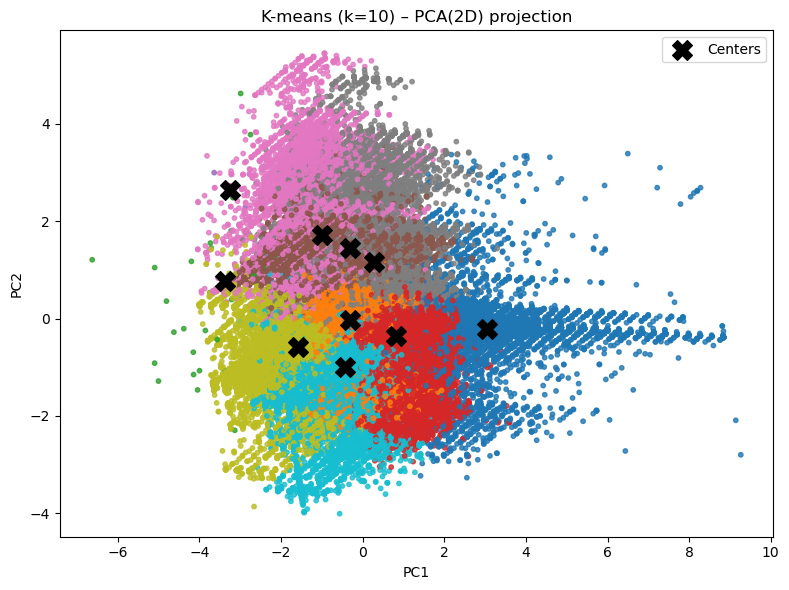

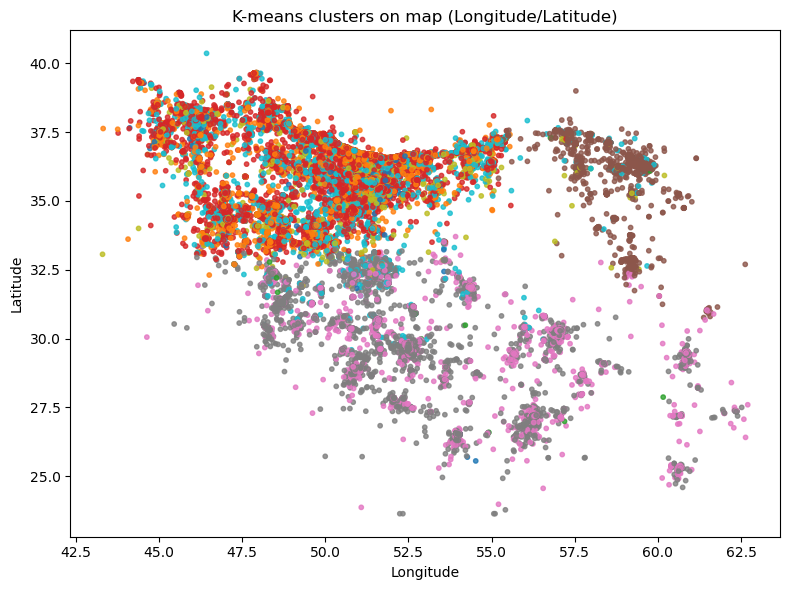

Cluster sizes: {0: 11573, 1: 64638, 2: 39, 3: 145363, 4: 2, 5: 50784, 6: 23941, 7: 44754, 8: 43276, 9: 85539}


In [8]:
# --- K-means (10 clusters) + Scaling + PCA visualization ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 10 فیچر انتخابی (فقط آن‌هایی که واقعاً در df موجودند نگه می‌داریم)
features = [
    "location_latitude","location_longitude","Y","building_size_final",
    "rooms_count","floor_final","construction_year","mode",
    "lux_count","necessary_count"
]
features = [f for f in features if f in df.columns]

# حذف سطرهای دارای NaN فقط در فیچرهای انتخابی
X = df[features].dropna()
idx = X.index  # برای برگرداندن برچسب‌ها به df اصلی

# اسکیلینگ (خیلی مهم برای K-means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-means با 10 خوشه
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10, max_iter=1000)
labels = kmeans.fit_predict(X_scaled)

# ذخیره‌ی برچسب خوشه در df اصلی
df.loc[idx, "kmeans_labels"] = labels

# کاهش بُعد برای نمایش (PCA به 2 بعد)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# مرکز خوشه‌ها را هم به فضای PCA ببریم
centers_pca = pca.transform(kmeans.cluster_centers_)

# --- Plot 1: نمایش خوشه‌ها در فضای PCA ---
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=10, cmap="tab10", alpha=0.8)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c="black", s=200, marker="X", label="Centers")
plt.title("K-means (k=10) – PCA(2D) projection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot 2: اگر مختصات موجودند، نمایش روی نقشه lat/long ---
if {"location_latitude","location_longitude"}.issubset(X.columns):
    plt.figure(figsize=(8,6))
    plt.scatter(
        X["location_longitude"], X["location_latitude"],
        c=labels, s=10, cmap="tab10", alpha=0.8
    )
    plt.title("K-means clusters on map (Longitude/Latitude)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout()
    plt.show()

# (اختیاری) نگاهی سریع به اندازه‌ی هر خوشه
unique, counts = np.unique(labels, return_counts=True)
cluster_sizes = dict(zip(unique, counts))
print("Cluster sizes:", cluster_sizes)




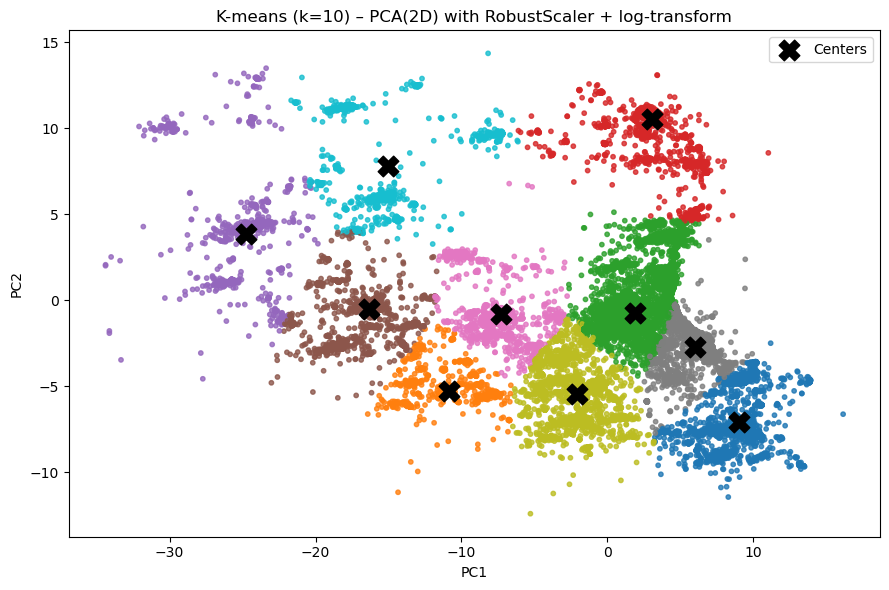

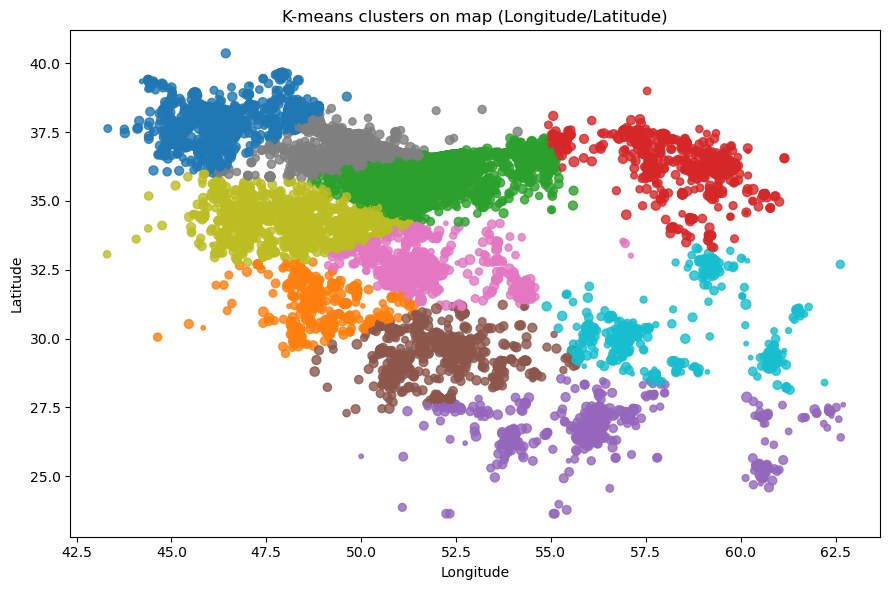

Cluster sizes: {0: 18037, 1: 14788, 2: 283444, 3: 51385, 4: 5857, 5: 23333, 6: 25518, 7: 22672, 8: 19413, 9: 5462}


In [9]:
# --- K-means (10 clusters) with log-transform + RobustScaler + PCA plot ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1) ساخت نسخه‌های لاگ برای فیچرهای چوله (اگر وجود داشته باشند)
if "Y" in df.columns:
    df["Y_log"] = np.log1p(df["Y"])  # log(1+Y)
if "building_size_final" in df.columns:
    df["building_size_log"] = np.log1p(df["building_size_final"])

# 2) انتخاب ۱۰ فیچر مهم (نسخه‌های لاگ را به‌جای خام می‌گذاریم)
features = [
    "location_latitude","location_longitude","Y_log","building_size_log",
    "rooms_count","floor_final","construction_year","mode",
    "lux_count","necessary_count"
]
features = [f for f in features if f in df.columns]

# 3) حذف ردیف‌های دارای NaN فقط در همین فیچرها
X = df[features].dropna()
idx = X.index  # برای ریختن برچسب‌ها داخل df اصلی

# (اختیاری) کنترل آوتلایر بعد از لاگ: کلیپ در صدک‌های 1% و 99%
for col in ["Y_log","building_size_log"]:
    if col in X.columns:
        q_low, q_hi = X[col].quantile([0.01, 0.99])
        X[col] = X[col].clip(q_low, q_hi)

# 4) Robust scaling (مقاوم به آوتلایر)
scaler = RobustScaler(quantile_range=(25, 75))
X_scaled = scaler.fit_transform(X)

# 5) K-means با 10 خوشه
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10, max_iter=1000)
labels = kmeans.fit_predict(X_scaled)
df.loc[idx, "kmeans_labels"] = labels

# 6) کاهش بُعد برای نمایش
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)

# 7) Plot: PCA
plt.figure(figsize=(9,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=10, cmap="tab10", alpha=0.8)
plt.scatter(centers_pca[:,0], centers_pca[:,1], c="black", s=220, marker="X", label="Centers")
plt.title("K-means (k=10) – PCA(2D) with RobustScaler + log-transform")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout(); plt.show()

# 8) Plot: روی نقشه اگر lat/long داریم
if {"location_latitude","location_longitude"}.issubset(X.columns):
    plt.figure(figsize=(9,6))
    sizes = 12
    if "Y_log" in X.columns:  # اندازه نقطه بر اساس قیمت (نمایشی)
        s0, s1 = X["Y_log"].min(), X["Y_log"].max()
        sizes = 10 + 40*(X["Y_log"]-s0)/(s1-s0 + 1e-9)
    plt.scatter(X["location_longitude"], X["location_latitude"],
                c=labels, s=sizes, cmap="tab10", alpha=0.8)
    plt.title("K-means clusters on map (Longitude/Latitude)")
    plt.xlabel("Longitude"); plt.ylabel("Latitude")
    plt.tight_layout(); plt.show()

# 9) اندازه‌ی خوشه‌ها
unique, counts = np.unique(labels, return_counts=True)
print("Cluster sizes:", dict(zip(unique, counts)))


بخش ۱)

حال الگوریتم خوشه‌بندی K-means را تنها بر حسب با ۱۰ خوشه برای این مجموعه‌داده اجرا کنید. سپس ابتدا مختصات جغرافیایی را به فرمت UTM درآورید و  برای دو ویژگی قیمت و مختصات UTM یک اسکترپلات رسم کنید. بر روی اسکتر پلات رسم‌شده مشخص کنید کدام نقاط مربوط به کدام خوشه هستند و مرکز هر خوشه را نیز رسم کنید. به انتخاب رنگ، مارکر، نام‌گذاری محور‌ها و به‌طور کلی قابل درک بودن تصویر دقت داشته باشید.


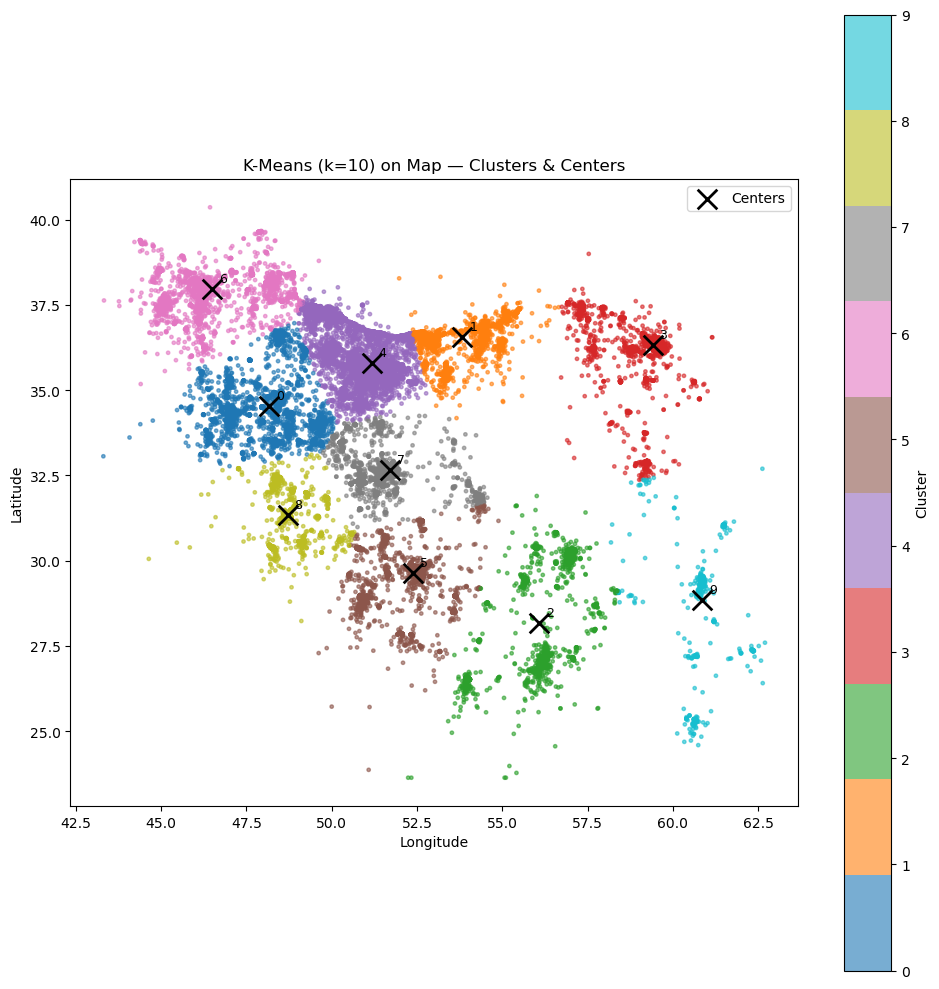

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# فرض: df["cluster"] و centers (با ترتیب ستون‌های [log_price, longitude, latitude]) وجود داره
from sklearn.cluster import KMeans

# مثلا KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
df["cluster"] = kmeans.fit_predict(df[["location_longitude", "location_latitude"]])
centers = kmeans.cluster_centers_

plt.figure(figsize=(10,10))
scatter = plt.scatter(
    df["location_longitude"].values, df["location_latitude"].values,
    c=df["cluster"].values, cmap="tab10", s=6, alpha=0.6
)

# مراکز خوشه‌ها (longitude, latitude)
plt.scatter(
    centers[:,0], centers[:,1],
    c="black", marker="x", s=200, linewidths=2, label="Centers"
)

# شماره‌گذاری مراکز
for i, (lon, lat) in enumerate(zip(centers[:,0], centers[:,1])):
    plt.annotate(str(i), (lon, lat), textcoords="offset points", xytext=(5,5),
                 fontsize=9, color="black")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("K-Means (k=10) on Map — Clusters & Centers")
plt.legend()
plt.colorbar(scatter, label="Cluster")
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


بخش ۲)

پس از آن الگوریتم K-means را برای k هایی از ۱ تا ۲۰ اجرا کرده و با محاسبه‌ی مجموع مجذورات درون خوشه‌ای  (Within-Cluster Sum of Square)، مقدار مناسبی برای هایپرپارامتر k انتخاب کنید. توجه کنید که بخش زیادی از نمره‌ی این بخش مربوط به نحوه‌ی انتخاب مقدار k است و چنان‌چه روش‌های تدریس‌شده و معمول پاسخگوی حل مسئله نبود،انتظار می‌رود با جستجو و مطالعه‌ی بیشتر، روشی مناسب برای رفع چالش‌های احتمالی پیشنهاد دهید.


In [15]:
import pandas as pd

df = pd.read_csv("Divar.csv")   

# ۱۰ فیچر پیشنهادی
cols = [
    "price_value","building_size","land_size","rooms_count","construction_year",
    "has_parking","has_elevator","has_balcony","has_pool","city_slug"
]

# انتخاب این ستون‌ها
df_sub = df[cols].copy()

# چک کردن خلاصه‌ای از وضعیت
print("تعداد کل ردیف‌ها:", len(df_sub))
print("\nدرصد داده‌های گم‌شده در هر ستون:")
print(df_sub.isna().mean().sort_values(ascending=False)*100)

print("\nنوع داده هر ستون:")
print(df_sub.dtypes)

print("\nچند ردیف نمونه:")
print(df_sub.head())


تعداد کل ردیف‌ها: 1000000

درصد داده‌های گم‌شده در هر ستون:
has_pool             97.0610
land_size            81.3604
has_balcony          49.3589
has_elevator         45.8251
price_value          43.1654
has_parking          27.1844
construction_year    18.4172
rooms_count          15.4101
building_size         1.9606
city_slug             0.0002
dtype: float64

نوع داده هر ستون:
price_value          float64
building_size        float64
land_size            float64
rooms_count           object
construction_year     object
has_parking           object
has_elevator          object
has_balcony           object
has_pool              object
city_slug             object
dtype: object

چند ردیف نمونه:
    price_value  building_size  land_size rooms_count construction_year  \
0           NaN          500.0        NaN          سه               NaN   
1  8.500000e+09           60.0        NaN          یک              ۱۳۸۴   
2           NaN          132.0        NaN          سه              ۱۴۰

In [16]:
%pip install kneed


Note: you may need to restart the kernel to use updated packages.


تعداد ردیف‌های استفاده‌شده: 200000
ویژگی‌ها: ['log_price', 'building_size', 'rooms_count', 'construction_year', 'has_parking', 'has_elevator', 'has_balcony', 'city_slug', 'property_type', 'cat3_slug']


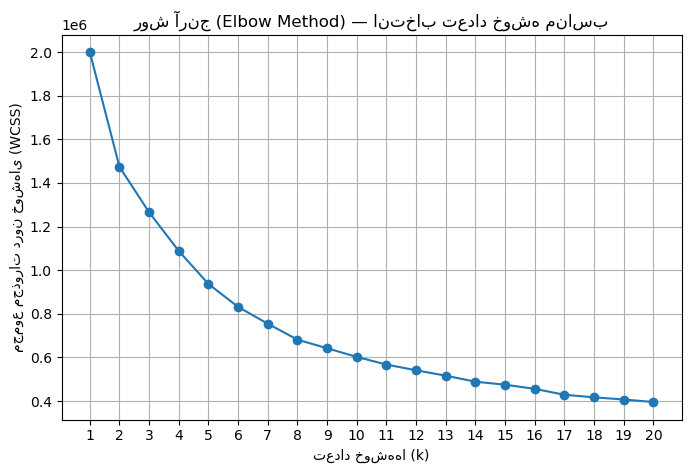

k بهینه (نقطه آرنج): 6


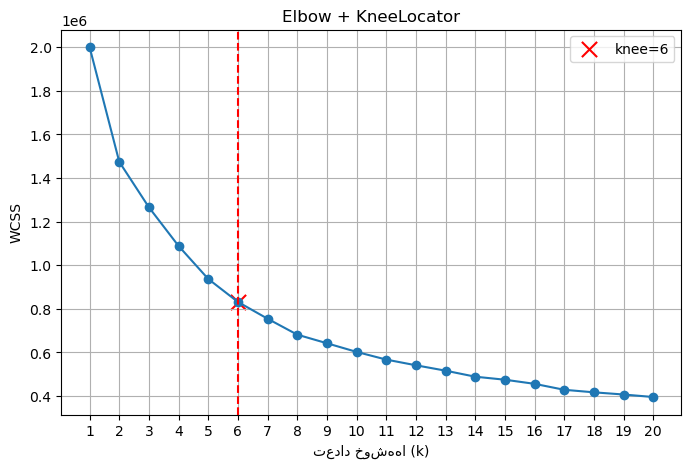

In [17]:
# === بخش ۲: انتخاب k با K-Means (Elbow + KneeLocator) روی 10 فیچر ===
# فیچرها: log_price, building_size, rooms_count, construction_year,
#         has_parking, has_elevator, has_balcony, city_slug(LE), property_type(LE), cat3_slug(LE)

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans

# اگر kneed نصب نیست، این خط را یک‌بار اجرا کن:
from kneed import KneeLocator

# ---------- تنظیمات ----------
CSV_PATH     = "/content/drive/MyDrive/divar/Divar.csv"
K_MIN, K_MAX = 1, 20
RANDOM_STATE = 42
N_INIT       = 10
MAX_ROWS     = 200_000   # برای سرعت (روی دیتاست‌های خیلی بزرگ)

# ---------- توابع کمکی (تبدیل و پاکسازی) ----------
def fa_to_en_digits(s):
    """تبدیل ارقام فارسی/عربی به انگلیسی"""
    if pd.isna(s): return s
    s = str(s)
    trans = str.maketrans("۰۱۲۳۴۵۶۷۸۹٠١٢٣٤٥٦٧٨٩", "01234567890123456789")
    return s.translate(trans)

num_word_map = {"یک":1,"دو":2,"سه":3,"چهار":4,"پنج":5,"شش":6,"هفت":7,"هشت":8,"نه":9,"ده":10}
def parse_rooms(x):
    """rooms_count: کلمات فارسی/ارقام فارسی→عدد؛ اگر نامعتبر بود NaN"""
    if pd.isna(x): return np.nan
    s = fa_to_en_digits(x).strip()
    if s in num_word_map: return float(num_word_map[s])
    m = re.search(r"\d+", s)
    return float(m.group()) if m else np.nan

def parse_year(x):
    """construction_year: استخراج سال 4 رقمی از متن/عدد فارسی"""
    if pd.isna(x): return np.nan
    s = fa_to_en_digits(x)
    m = re.search(r"(1[0-9]{3}|2[0-9]{3})", s)  # 1000..2999
    return float(m.group()) if m else np.nan

def to_bin(x):
    """تبدیل امکانات به 0/1 (True/yes/بله/1 → 1)"""
    if pd.isna(x): return 0
    s = str(x).strip().lower()
    return 1 if s in {"1","true","yes","y","بله","وجود دارد","true/true","true,true"} else 0

# ---------- 1) خواندن و انتخاب ستون‌ها ----------
use_cols = [
    "price_value","building_size","rooms_count","construction_year",
    "has_parking","has_elevator","has_balcony",
    "city_slug","property_type","cat3_slug"
]

df = pd.read_csv("Divar.csv", usecols=use_cols)


# ---------- 2) پاکسازی و تبدیل ----------
# قیمت
df["price_value"] = pd.to_numeric(df["price_value"], errors="coerce")
df = df[df["price_value"] > 0]  # حذف قیمت‌های نامعتبر
df["log_price"]  = np.log1p(df["price_value"])

# اندازه بنا
df["building_size"] = pd.to_numeric(df["building_size"], errors="coerce")
df["building_size"] = df["building_size"].fillna(df["building_size"].median())

# اتاق و سال ساخت
df["rooms_count"]       = df["rooms_count"].apply(parse_rooms)
df["construction_year"] = df["construction_year"].apply(parse_year)

# پرکردن مقادیر خالی با میانه/صفر
df["rooms_count"]       = df["rooms_count"].fillna(0)
df["construction_year"] = df["construction_year"].fillna(df["construction_year"].median())

# امکانات به 0/1
for b in ["has_parking","has_elevator","has_balcony"]:
    df[b] = df[b].apply(to_bin).astype(int)

# کدگذاری متنی (Label Encoding)
for cat_col in ["city_slug","property_type","cat3_slug"]:
    df[cat_col] = df[cat_col].astype(str).fillna("unknown")
    le = LabelEncoder()
    df[cat_col] = le.fit_transform(df[cat_col])

# ---------- 3) ساخت ماتریس ویژگی نهایی (10 فیچر) ----------
feature_cols = [
    "log_price","building_size","rooms_count","construction_year",
    "has_parking","has_elevator","has_balcony",
    "city_slug","property_type","cat3_slug"
]
X_df = df[feature_cols].copy()

# نمونه‌گیری برای سرعت (اختیاری)
if len(X_df) > MAX_ROWS:
    X_df = X_df.sample(n=MAX_ROWS, random_state=RANDOM_STATE)

# اسکیل
scaler = StandardScaler()
X = scaler.fit_transform(X_df)

print(f"تعداد ردیف‌های استفاده‌شده: {len(X_df)}")
print("ویژگی‌ها:", feature_cols)

# ---------- 4) اجرای KMeans برای k=1..20 و محاسبه‌ی WCSS ----------
k_values = list(range(K_MIN, K_MAX+1))
wcss = []
for k in k_values:
    km = KMeans(n_clusters=k, init="k-means++", n_init=N_INIT, random_state=RANDOM_STATE)
    km.fit(X)
    wcss.append(km.inertia_)   # WCSS / Inertia

# نمودار Elbow
plt.figure(figsize=(8,5))
plt.plot(k_values, wcss, marker="o")
plt.xticks(k_values)
plt.xlabel("تعداد خوشه‌ها (k)")
plt.ylabel("مجموع مجذورات درون خوشه‌ای (WCSS)")
plt.title("روش آرنج (Elbow Method) — انتخاب تعداد خوشه مناسب")
plt.grid(True)
plt.show()

# ---------- 5) تشخیص خودکار نقطه آرنج ----------
kneedle = KneeLocator(k_values, wcss, curve="convex", direction="decreasing")
best_k = kneedle.knee
print("k بهینه (نقطه آرنج):", best_k)

if best_k is not None:
    plt.figure(figsize=(8,5))
    plt.plot(k_values, wcss, marker="o")
    plt.axvline(best_k, color="red", linestyle="--")
    plt.scatter(best_k, wcss[best_k-1], c="red", s=120, marker="x", label=f"knee={best_k}")
    plt.xticks(k_values)
    plt.xlabel("تعداد خوشه‌ها (k)")
    plt.ylabel("WCSS")
    plt.title("Elbow + KneeLocator")
    plt.grid(True)
    plt.legend()
    plt.show()


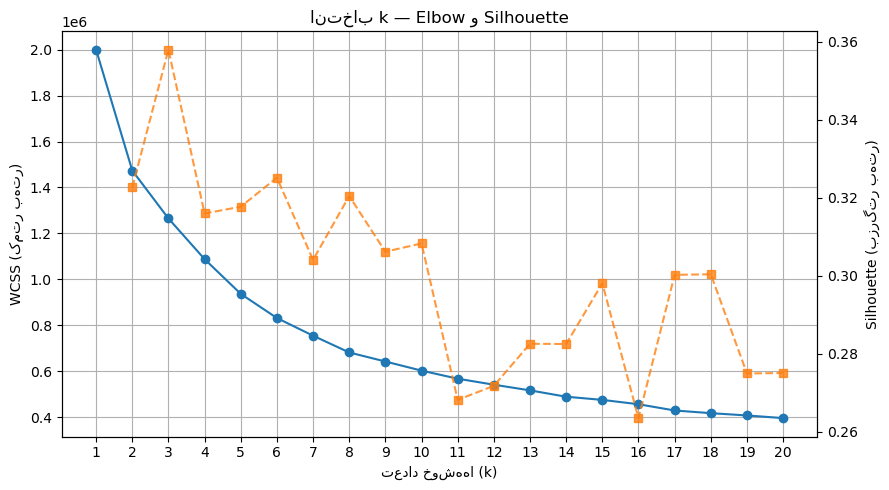

✅ k پیشنهادی بر اساس بیشینه Silhouette: 3
تعداد ردیف‌های استفاده‌شده: 200000
Features: ['log_price', 'building_size', 'rooms_count', 'construction_year', 'has_parking', 'has_elevator', 'has_balcony', 'city_slug', 'property_type', 'cat3_slug']


In [18]:
# === Compact K-selection (10 features) — Elbow + Silhouette ===
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# ---------- Config ----------
CSV_PATH     = "/content/drive/MyDrive/divar/Divar.csv"
K_MIN, K_MAX = 1, 20
RANDOM_STATE = 42
N_INIT       = 10
MAX_ROWS     = 200_000     # برای سرعت
SILH_SAMP    = 30_000      # نمونه برای سیلوئت

# ---------- Helpers (فارسی→انگلیسی، پارس) ----------
def fa_to_en_digits(s):
    if pd.isna(s): return s
    return str(s).translate(str.maketrans("۰۱۲۳۴۵۶۷۸۹٠١٢٣٤٥٦٧٨٩","01234567890123456789"))

NUM_WORD = {"یک":1,"دو":2,"سه":3,"چهار":4,"پنج":5,"شش":6,"هفت":7,"هشت":8,"نه":9,"ده":10}
def parse_rooms(x):
    if pd.isna(x): return np.nan
    s = fa_to_en_digits(x).strip()
    if s in NUM_WORD: return float(NUM_WORD[s])
    m = re.search(r"\d+", s)
    return float(m.group()) if m else np.nan

def parse_year(x):
    if pd.isna(x): return np.nan
    s = fa_to_en_digits(x)
    m = re.search(r"(1[0-9]{3}|2[0-9]{3})", s)
    return float(m.group()) if m else np.nan

def to_bin(x):
    if pd.isna(x): return 0
    s = str(x).strip().lower()
    return 1 if s in {"1","true","yes","y","بله","وجود دارد"} else 0

# ---------- Load & minimal prep ----------
use_cols = [
    "price_value","building_size","rooms_count","construction_year",
    "has_parking","has_elevator","has_balcony",
    "city_slug","property_type","cat3_slug"
]
df = pd.read_csv("Divar.csv", usecols=use_cols, low_memory=False)

# price → log_price
df["price_value"] = pd.to_numeric(df["price_value"], errors="coerce")
df = df[df["price_value"] > 0]
df["log_price"] = np.log1p(df["price_value"])

# numeric cleans
df["building_size"] = pd.to_numeric(df["building_size"], errors="coerce")
df["building_size"] = df["building_size"].fillna(df["building_size"].median())

df["rooms_count"]       = df["rooms_count"].apply(parse_rooms).fillna(0)
df["construction_year"] = df["construction_year"].apply(parse_year)
df["construction_year"] = df["construction_year"].fillna(df["construction_year"].median())

# binaries
for b in ["has_parking","has_elevator","has_balcony"]:
    df[b] = df[b].apply(to_bin).astype(int)

# label encoding for categoricals
for cat in ["city_slug","property_type","cat3_slug"]:
    df[cat] = df[cat].astype(str)
    df[cat] = LabelEncoder().fit_transform(df[cat])

# final 10 features
feat = ["log_price","building_size","rooms_count","construction_year",
        "has_parking","has_elevator","has_balcony",
        "city_slug","property_type","cat3_slug"]
X_df = df[feat].copy()

# sampling (speed)
if len(X_df) > MAX_ROWS:
    X_df = X_df.sample(MAX_ROWS, random_state=RANDOM_STATE)

# scale
X = StandardScaler().fit_transform(X_df)

# ---------- Grid over k ----------
k_vals = list(range(K_MIN, K_MAX+1))
wcss, silh = [], []

for k in k_vals:
    km = KMeans(n_clusters=k, init="k-means++", n_init=N_INIT, random_state=RANDOM_STATE)
    labels = km.fit_predict(X)
    wcss.append(km.inertia_)
    if k >= 2:
        if len(X) > SILH_SAMP:
            idx = np.random.RandomState(RANDOM_STATE).choice(len(X), SILH_SAMP, replace=False)
            silh.append(silhouette_score(X[idx], labels[idx]))
        else:
            silh.append(silhouette_score(X, labels))
    else:
        silh.append(np.nan)

# ---------- Plots (Elbow + Silhouette) ----------
fig, ax1 = plt.subplots(figsize=(9,5))
ax1.plot(k_vals, wcss, marker="o")
ax1.set_xlabel("تعداد خوشه‌ها (k)")
ax1.set_ylabel("WCSS (کمتر بهتر)")
ax1.set_title("انتخاب k — Elbow و Silhouette")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(k_vals, silh, marker="s", linestyle="--", alpha=0.8, color="tab:orange")
ax2.set_ylabel("Silhouette (بزرگ‌تر بهتر)")

plt.xticks(k_vals)
plt.tight_layout()
plt.show()

# پیشنهاد k: حداکثر سیلوئت (از k≥2)
valid = [(k,s) for k,s in zip(k_vals, silh) if not np.isnan(s)]
best_k = max(valid, key=lambda t: t[1])[0] if valid else None
print("✅ k پیشنهادی بر اساس بیشینه Silhouette:", best_k)
print("تعداد ردیف‌های استفاده‌شده:", len(X_df))
print("Features:", feat)


In [19]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# فرض: X = داده‌های نرمال‌شده، labels = خروجی KMeans
sil = silhouette_score(X, labels)
dbi = davies_bouldin_score(X, labels)
ch  = calinski_harabasz_score(X, labels)

print("Silhouette Score:", sil)
print("Davies-Bouldin Index:", dbi)
print("Calinski-Harabasz Index:", ch)


Silhouette Score: 0.2746444325824949
Davies-Bouldin Index: 1.1984970484109578
Calinski-Harabasz Index: 42726.89609902347
